In [309]:
E_min = 10
E_max = 150
n_disks = 25

25

In [2]:
using HDF5
using JSON
using Plots, LinearAlgebra, Statistics, Random, StatsBase, Compat, Distributions

function modify_25(arr)
        return [sum(arr[(1 + i * 4):(4 + i * 4)]) for i in range(0, stop=24)]
    end

modify_25 (generic function with 1 method)

In [3]:
data_p = Dict()

filenames = ["mcmc_1_69.hdf5", "mcmc_70_99.hdf5", "mcmc_100_119.hdf5",
"mcmc_120_139.hdf5", "mcmc_140_150.hdf5"];

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [modify_25(elem.data[1]) for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0
            if !haskey(data_p, energy_value)
                data_p[energy_value] = []
            end
            append!(data_p[energy_value], data_array)
        end
    end

    close(ligo)
end


mcmc_1_69.hdf5
mcmc_70_99.hdf5
mcmc_100_119.hdf5
mcmc_120_139.hdf5
mcmc_140_150.hdf5


In [4]:
include("../../statreg_materials/StatReg.jl/src/StatReg.jl")
using .StatReg


plotly()
gr(size=(500,500), html_output_format=:png)

GLOBAL_RNG = 123
Random.seed!(123);

In [310]:
using Memoize

@memoize function K_p(E, y)
    return mean([elem[y] for elem in data_p[E]])
end


energy_p = sort(collect(keys(data_p)))
energy_p = energy_p[[x >= E_min for x in energy_p]];

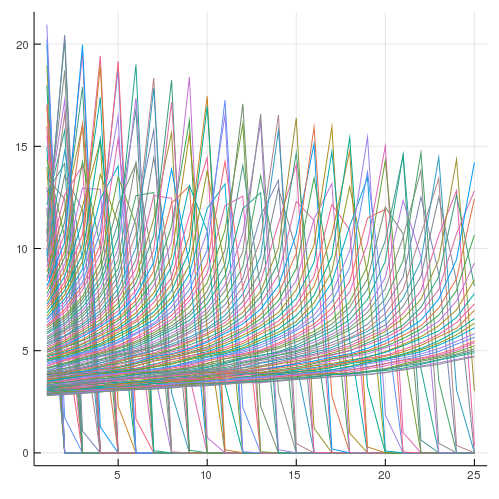

In [311]:
p = plot()
for e in energy_p
    p = plot!(collect(range(1, stop=n_disks)), [K_p(e, y_) for y_ in collect(range(1, stop=n_disks))], label="")
end
display(p)

In [312]:
function create_spectrum_p(n_energy, energy_p)
    arr = []
    for (n, i) in zip(n_energy, energy_p)
        value = data_p[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum_p (generic function with 1 method)

In [313]:
function real_spectrum_p(E)
    C = 1.35 * 10^9
    ga = 1.04
    gb = 3.52
    E0 = 27.4
    dt = 1.19 * 10^5
    S = 10
    
    if E < (gb - ga) * E0
        return C * E^(-ga) * exp(- E / E0) / dt * S
    else
        return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * S
    end
end

real_spectrum_p (generic function with 1 method)

In [314]:
arr_spectrum_real_p = [floor(Int, real_spectrum_p(x_)) for x_ in energy_p]
f_y_p = create_spectrum_p(arr_spectrum_real_p, energy_p);

# plot(f_y_p, dpi=400,
#     xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
#     ylabel="energy deposition, MeV", xlabel="N", yscale=:log10,# xscale=:log10,
#     minorgrid=true, yticks=[10^4, 10^5, 10^6], label="")
# savefig("deposition25.png")

In [315]:
@memoize function K_cont_p(E, y)
    if E in energy_p
        return K_p(E, y)
    end
    E_max = energy_p[findfirst(x -> x>=E, energy_p)]
    E_min = energy_p[findlast(x -> x<=E, energy_p)]
    return (K_p(E_min, y) * (E_max - E) + K_p(E_max, y) * (E - E_min)) / (E_max - E_min)
end

K_cont_p (generic function with 1 method)

In [316]:
sig = 0.01*f_y_p + [max(sqrt(i), 1) for i in f_y_p]
f = f_y_p;

In [317]:
a = E_min
b = E_max
basis = CubicSplineBasis(a, b, 60, (nothing, "dirichlet"));
Omega = omega(basis);


┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:107
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


In [318]:
model = GaussErrorUnfolder(basis, [Omega], "User", alphas=[0.1440379000137214]);

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [319]:
# K_p_matrix = discretize_kernel(basis, K_cont_p, collect(range(1, stop=n_disks)));

In [320]:
# res = K_p_matrix \ f;

In [321]:
# result_matrix = Dict()
# result_matrix["coeff"] = res
# phivec_matrix = PhiVec(result_matrix, basis)
# x = collect(range(a, 100, length=500))
# phi_reconstructed_matrix = phivec_matrix.phi_function.(x)

# plot(energy_p[1:90], arr_spectrum_real_p[1:90], label="Real spectrum", color=:red)#,
#     #yscale=:log10, xscale=:log10)
# plot!(x, phi_reconstructed_matrix,# ribbon=phi_reconstructed_errors, fillalpha=0.3,
#     label="Reconstructed spectrum", xlabel="E, MeV", ylabel="dN/dE", color = :blue,
#     xtickfontsize=14,ytickfontsize=14, legendfontsize=12, guidefont=font(12), dpi=400)#,
    #yscale=:log10, xscale=:log10)
# savefig("matrix_solution_25.png")

In [322]:
# arr_rec = phivec_matrix.phi_function.(energy_p)
# for_plot = [abs(arr_rec[i]-arr_spectrum_real_p[i])/arr_spectrum_real_p[i] for i in range(1, stop=length(arr_spectrum_real_p[1:100]))]
# print(mean(for_plot))
# plot(for_plot, linestyle=:dot)

In [323]:
@time result = solve(model, K_cont_p, f, sig, collect(range(1, stop=n_disks)));

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44


 10.732705 seconds (270.11 M allocations: 6.980 GiB, 29.09% gc time)


┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:202


┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


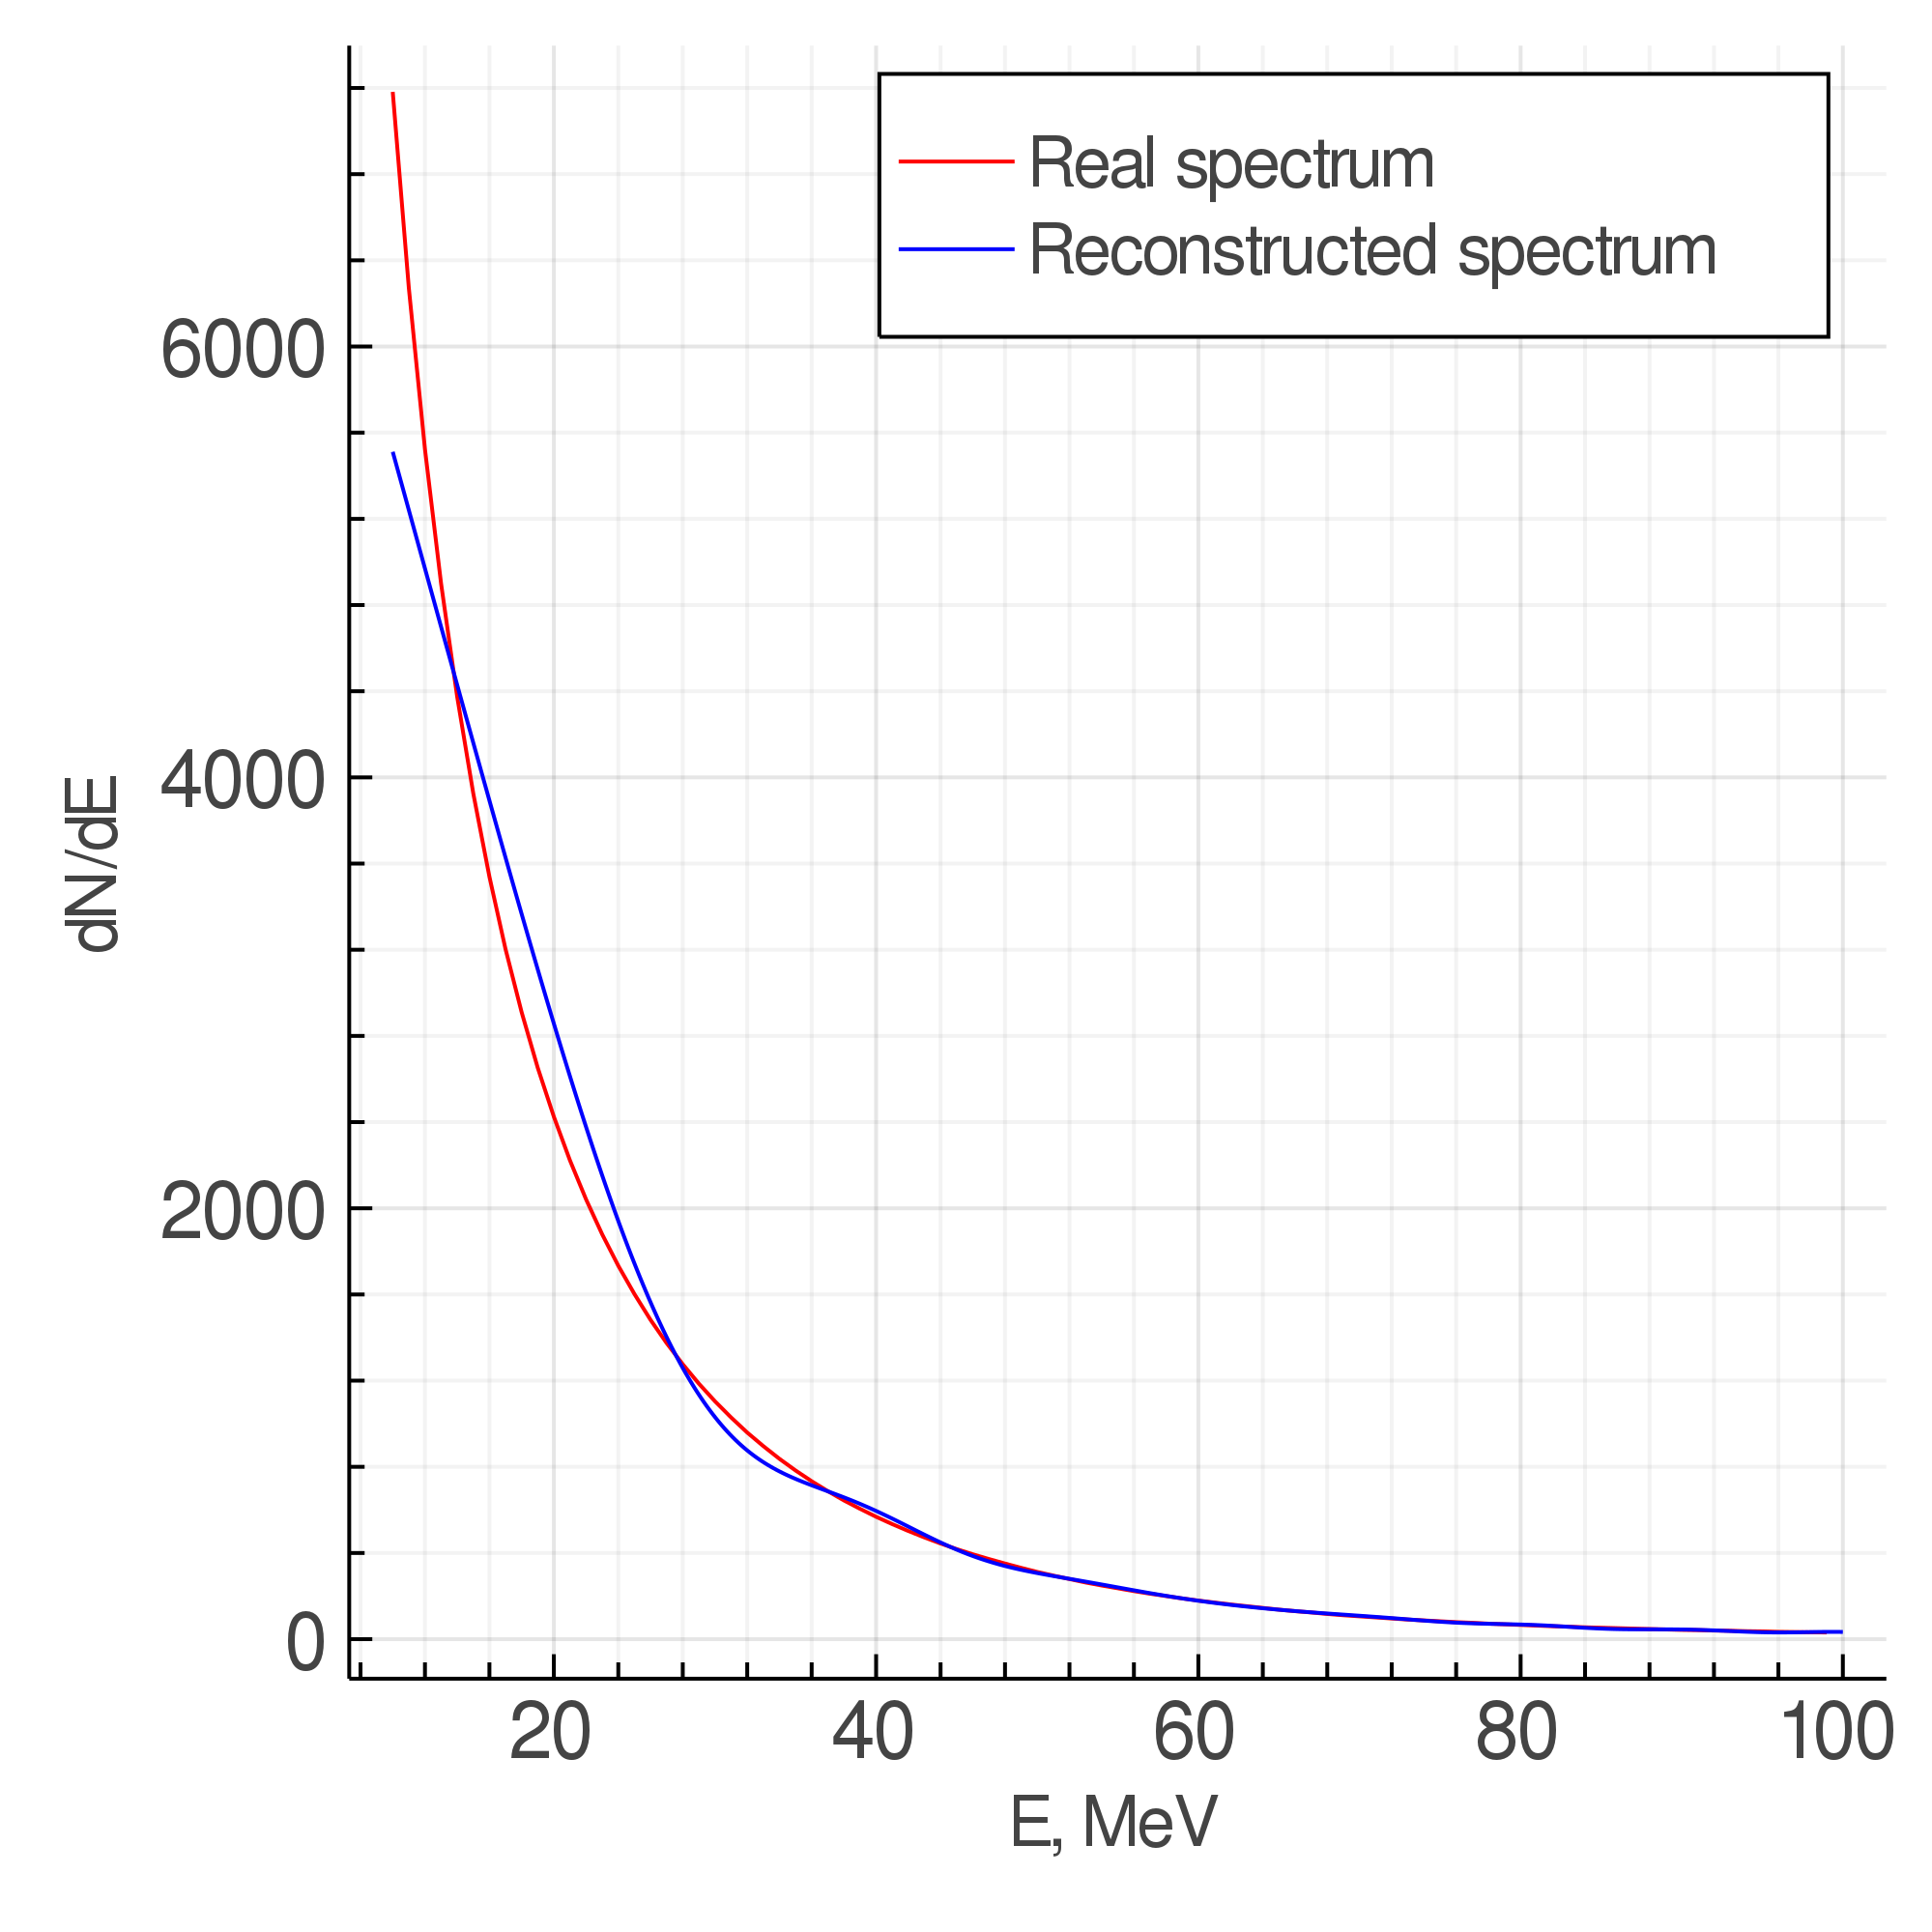

In [324]:
x = collect(range(a, 100, length=500))
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(energy_p[1:90], arr_spectrum_real_p[1:90], label="Real spectrum", color=:red)#,
    #yscale=:log10, xscale=:log10)
plot!(x, phi_reconstructed,# ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="E, MeV", ylabel="dN/dE", color = :blue,
    xtickfontsize=14,ytickfontsize=14, legendfontsize=12, guidefont=font(12), dpi=400, minorgrid=true)#,
    #yscale=:log10, xscale=:log10)
# savefig("reconstructed_25_from_10.png")

0.04860990889625788

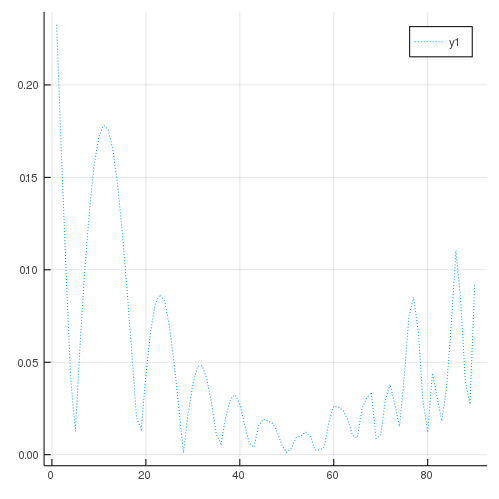

In [325]:
arr_rec = phivec.phi_function.(energy_p)
for_plot = [abs(arr_rec[i]-arr_spectrum_real_p[i])/arr_spectrum_real_p[i] for i in range(1, stop=length(arr_spectrum_real_p[1:90]))]
print(mean(for_plot))
plot(for_plot, linestyle=:dot)